In [43]:
import torch
import torch.nn as nn
import os
import datetime
import numpy as np
import nltk
import csv
import json
from data_loader import get_loader
from torchvision import transforms
import torchvision
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from build_vocab import Vocabulary
from pycocotools.coco import COCO
from cnn_rnn_fcn import *
import time
from generate_results import indices2sentence
import matplotlib.pyplot as plt

In [44]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_image_directory = './data/images/test/'
test_caption_directory = './data/annotations/captions_val2014.json'

coco_test = COCO(test_caption_directory)

with open('TestImageIds.csv', 'r') as f_test:
    reader_test = csv.reader(f_test)
    test_ids = list(reader_test)
test_ids = [int(i) for i in test_ids[0]]
test_ann_ids = coco_test.getAnnIds(test_ids)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [45]:
batch_size = 10

vocab = Vocabulary()

transform_test = transforms.Compose([
                                transforms.Resize(224),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                            ])

test_loader = get_loader(test_image_directory,
                          test_caption_directory,
                          ids= test_ann_ids,
                          vocab= vocab,
                          transform=transform_test,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=10)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [46]:
end_id = vocab.word2ind['<end>']
print("end_idx:",end_id)

end_idx: 1


In [47]:
encoder = torch.load('./2020-02-26_09-29-17/best_model_encoder')
decoder = torch.load('./2020-02-26_09-29-17/best_model_decoder')

[[0, 1370, 5321, 7848, 2278, 8701, 1370, 7041, 5055, 7418, 9544, 12437, 1, 1, 12437, 1, 1, 12437, 1, 1], [0, 1370, 10289, 7848, 1933, 9528, 1370, 5064, 4369, 1370, 4331, 12437, 1, 1, 1, 12437, 1, 1, 12437, 1], [0, 1370, 7408, 7418, 7743, 9702, 2879, 6828, 1370, 250, 12437, 1, 1, 12437, 1, 1, 12437, 1, 1, 12437], [0, 1370, 7433, 7418, 989, 9528, 1370, 1162, 4369, 1370, 4946, 7418, 989, 12437, 1, 1, 12437, 1, 1, 12437], [0, 1370, 6592, 6828, 1370, 5912, 5695, 7848, 4401, 1370, 4080, 12437, 1, 1, 12437, 1, 1, 12437, 1, 1], [0, 1370, 6592, 7848, 9564, 4369, 1370, 4080, 6828, 4943, 7832, 12437, 1, 1, 1, 12437, 1, 1, 12437, 1], [0, 1370, 7788, 7866, 4369, 1370, 7788, 9528, 6673, 7418, 5738, 12437, 1, 1, 1, 12437, 1, 1, 12437, 1], [0, 1370, 6592, 7848, 2879, 4814, 3873, 1370, 10732, 7418, 1689, 12437, 1, 1, 12437, 1, 1, 12437, 1, 1], [0, 1370, 10915, 4369, 1370, 8787, 10809, 1370, 6099, 12437, 1, 1, 1, 1, 12437, 1, 1, 1, 12437, 1], [0, 1370, 6592, 1933, 9528, 1370, 5064, 4369, 1370, 3974, 124

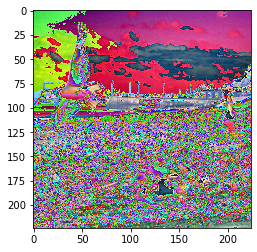

In [49]:
for iter, (images, captions, length, meta_data) in enumerate(test_loader):
    images = images.to(device)
    captions = captions.to(device)

    with torch.no_grad():
        image_features = encoder(images)
        output_caption = decoder.generate(image_features)
        
    print(output_caption)
    plt.figure()
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(images[0].cpu()).convert("RGB")
    plt.imshow(img)
    sentance = indices2sentence(output_caption[0])
    print("Our output:",sentance)
    sentance = indices2sentence(captions[0].cpu().detach().numpy())
    print("Ground truth caption:",sentance)
    break